## Non-normal Naive Bayes Classifier

In this section, we will implement a non-normal Naive Bayes classifier. Unlike the standard Naive Bayes classifier, which assumes that the features follow a normal distribution, the non-normal Naive Bayes classifier makes no such assumptions.

Having explored the dataset beforehand, we know that the features do not follow a normal distribution. However, most of them seem to follow parametric distributions such as exponential, Poisson, or multinomial distributions. For that reason, three different non-normal Naive Bayes classifiers will be implemented: In the first one, we will use histogram-based probability density estimation for each continuous feature. In the second one, we will use kernel density estimation (KDE) for each continuous feature. Finally, in the third one, we will attempt to discover the underlying parametric distribution of each feature and use that information to build the classifier.

Let us start by loading the data, removing unnecessary columns, preprocessing the rest, and splitting it into training and test sets. This part is similar to what we did in the previous sections. However, because the density estimation methods we will use in this section are tunable (e.g., number of bins in histograms, bandwidth in KDE), we will also implement a K-fold cross-validation procedure to find the best hyperparameters for each method.

In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv("../data/raw/higgs-challenge.csv.gz", compression="gzip")
df = df.drop(columns=["EventId", "KaggleSet", "KaggleWeight"])
df.replace(-999.0, np.nan, inplace=True)  # Missing values are represented as -999.0
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,...,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226,0.681042,b
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251,0.715742,b
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000,1.660654,b
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.904263,b


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Label", "Weight"])
weight = df["Weight"]  # Only used to compute the AMS metric
y = df["Label"]
# Stratify to maintain class distribution
X_train, X_test, weight_train, weight_test, y_train, y_test = train_test_split(
    X, weight, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, weight_train.shape, weight_test.shape, y_train.shape, y_test.shape

((654590, 30), (163648, 30), (654590,), (163648,), (654590,), (163648,))

### Non-normal Naive Bayes Classifier with Histogram-based Estimation

Let us start by implementing a trivial non-normal Naive Bayes classifier that uses histogram-based probability density estimation for each continuous feature. The idea is to create histograms for each feature conditioned on the class labels and use these histograms to estimate the likelihoods during prediction.

In [ ]:
from typing import Optional
from sklearn.naive_bayes import _BaseNB
import numpy as np
from sklearn.utils.validation import validate_data
from numpy.typing import NDArray
from typing import TypeVar
from typing import List

YType = TypeVar("YType", bound=np.generic)


class HistogramNB(_BaseNB):
    """
    Histogram Naive Bayes (HistogramNB).

    Note: This implementation does not support N/A values in the input data.

    Args:
        bin_count (Optional[int]): Number of bins to use for histogram estimation.
            If None, each histogram will use a number of bins equal to the square
            root of the number of samples.
    """

    _priors: NDArray[np.float64]
    _class_counts: NDArray[np.float64]
    _class_histograms: List[NDArray[np.float64]]
    _bin_edges: List[NDArray[np.float64]]
    classes_: NDArray[YType]

    def __init__(self, bin_count: Optional[int] = None):
        self.bin_count = bin_count
        super().__init__()

    def fit(self, X: NDArray[np.float64], y: NDArray[YType]):
        """Fit Histogram Naive Bayes according to X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples
            and `n_features` is the number of features. It cannot contain N/A
            values.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X, y = validate_data(self, X, y, reset=True)
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        self._class_counts = np.zeros(n_classes, dtype=np.float64)
        self._class_histograms = [None] * n_classes
        self._bin_edges = [None] * n_classes

        for i, y_i in enumerate(self.classes_):
            X_i = X[y == y_i, :]
            N_i = X_i.shape[0]

            # Placeholder: Update the histograms
            if self.bin_count is None:
                bin_count = int(np.sqrt(N_i))
            else:
                bin_count = self.bin_count
            self._class_histograms[i] = np.empty((X.shape[1], bin_count))
            self._bin_edges[i] = np.empty((X.shape[1], bin_count + 1))
            for feature_idx in range(X.shape[1]):
                self._class_histograms[i][feature_idx], self._bin_edges[i][feature_idx] = np.histogram(
                    X_i[:, feature_idx], bins=bin_count, density=True
                )

            self._class_counts[i] += N_i

        self._priors = self._class_counts / self._class_counts.sum()

        return self

    def _joint_log_likelihood(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        # TODO: Check this implementation again... (It was vibe coded at 2 AM)
        joint_log_likelihood = []
        for i, y_i in enumerate(self.classes_):
            log_likelihood = np.log(self._priors[i]) * np.ones(X.shape[0])
            for feature_idx in range(X.shape[1]):
                bin_edges = self._bin_edges[i][feature_idx]
                hist = self._class_histograms[i][feature_idx]
                bin_indices = np.digitize(X[:, feature_idx], bin_edges) - 1
                bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
                likelihoods = hist[bin_indices] * np.diff(bin_edges)[bin_indices]
                likelihoods[likelihoods == 0] = 1e-9  # Avoid log(0)
                log_likelihood += np.log(likelihoods)
            joint_log_likelihood.append(log_likelihood)
        return np.array(joint_log_likelihood).T

    def _check_X(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Validate X against the training data."""
        X = validate_data(self, X, reset=False)
        return X

This implementation has a `n_bins` hyperparameter that specifies the number of bins to use for the histograms. We will use K-fold cross-validation to find the best value for this hyperparameter. But first, let us perform a quick training run with `bin_count` set to 10, and all the learning data to see how well this classifier performs without any hyperparameter tuning.

Because there are some missing values in the dataset, which this method doesn't allow, we will drop any rows that contain missing values for any methods that do not support N/A.

In [ ]:
X_clean_train = X_train.dropna()
y_clean_train = y_train[X_clean_train.index]
weight_clean_train = weight_train[X_clean_train.index]
X_clean_test = X_test.dropna()
y_clean_test = y_test[X_clean_test.index]
weight_clean_test = weight_test[X_clean_test.index]
X_clean_train.shape, y_clean_train.shape, X_clean_test.shape, y_clean_test.shape

Note that this could lead to a significant reduction in the size of the dataset, as well as a potential bias if the missingness is not completely at random (which we have strong reasons to believe it is not), and could lead to errors in the inference runtime.

In [14]:
model = HistogramNB(bin_count=10)
model.fit(X_clean_train.to_numpy(), y_clean_train.to_numpy())

y_pred = model.predict(X_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_clean_test.to_numpy(), y_pred)
report = classification_report(y_clean_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6756
              precision    recall  f1-score   support

           b       0.63      0.92      0.75     23886
           s       0.82      0.39      0.53     20952

    accuracy                           0.68     44838
   macro avg       0.73      0.66      0.64     44838
weighted avg       0.72      0.68      0.65     44838



An alternative, more safe approach to removing missing values would be to remove the columns that contain missing values instead of the rows. This can potentially lead to an increase of both the error and the bias, as we would be removing potentially useful features. However, it would not reduce the size of the dataset, and it is less likely that it would not lead to errors during inference (in the training dataset, only 11 features have any missing values).

In [9]:
columns_with_na = X.columns[X.isna().any()].tolist()
columns_with_na

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi']

In [10]:
X_col_clean_train = X_train.drop(columns=columns_with_na)
X_col_clean_test = X_test.drop(columns=columns_with_na)

In [15]:
model = HistogramNB(bin_count=10)
model.fit(X_col_clean_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_col_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6649
              precision    recall  f1-score   support

           b       0.72      0.81      0.76    107736
           s       0.51      0.39      0.45     55912

    accuracy                           0.66    163648
   macro avg       0.62      0.60      0.60    163648
weighted avg       0.65      0.66      0.65    163648



Finally, let us introduce a new version of the HistogramNB which will accept N/A values. This version will estimate each feature's distribution using a combination of their histogram and the missingness pattern. We will define the probability density* function as follows:
$$
    p(x_i|y=c) = 
    \begin{cases}
        p^{NA} & \text{if } x_i \text{ is missing} \\
        (1-p^{NA})\cdot f_{i,c}(x_i) & \text{if } x_i \text{ is observed}
    \end{cases}
$$

Where $p^{NA}$ is the probability of missingness for feature $i$ given class $c$, and $f_{i,c}(x_i)$ is the probability density function estimate for feature $i$ given class $c$. This way, we can account for the missingness in our density estimates. Interestingly enough, this approach also accounts for the possibility of Laplace smoothing, as we can add a small amount to $p^{NA}$ such that the model remains robust even to missing data in features not seen missing in the training set.

We'll call this custom classifier `RobustHistogramNB`. Let's implement it and evaluate its performance on the dataset.

In [130]:
from typing import Optional
from sklearn.naive_bayes import _BaseNB
import numpy as np
from sklearn.utils.validation import validate_data
from numpy.typing import NDArray
from typing import TypeVar
from typing import List

YType = TypeVar("YType", bound=np.generic)


class RobustHistogramNB(_BaseNB):
    """
    Robust Histogram Naive Bayes (RobustHistogramNB).

    This implementation is designed to be completely robust to missing values
    both in the training and prediction phases. If a feature is missing in the
    training stage, its missingness is considered as a separate "bin" in the
    histogram. This allows the model to learn from the absence of data as well.

    Args:
        bin_count (Optional[int]): Number of bins to use for histogram estimation.
            If None, each histogram will use a number of bins equal to the square
            root of the number of samples.
    """

    _priors: NDArray[np.float64]
    _class_counts: NDArray[np.float64]
    _class_histograms: List[NDArray[np.float64]]
    _bin_edges: List[NDArray[np.float64]]
    _missing_value_probabilities: NDArray[np.float64]
    _num_features: int
    _num_classes: int
    classes_: NDArray[YType]

    def __init__(self, bin_count: Optional[int] = None, laplace_smoothing: float = 1e-9):
        self.bin_count = bin_count
        self.laplace_smoothing = laplace_smoothing
        super().__init__()

    def fit(self, X: NDArray[np.float64], y: NDArray[YType]):
        """Fit Robust Histogram Naive Bayes according to X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X, y = validate_data(self, X, y, reset=True, ensure_all_finite="allow-nan")
        self._num_features = X.shape[1]
        self.classes_ = np.unique(y)
        self._num_classes = len(self.classes_)
        self._class_counts = np.zeros(self._num_classes, dtype=np.float64)
        self._class_histograms = [None] * self._num_classes
        self._bin_edges = [None] * self._num_classes
        self._missing_value_probabilities = np.zeros((self._num_classes, X.shape[1]), dtype=np.float64)

        for i, y_i in enumerate(self.classes_):
            X_i = X[y == y_i, :]
            N_i = X_i.shape[0]

            # Placeholder: Update the histograms
            if self.bin_count is None:
                bin_count = int(np.sqrt(N_i))
            else:
                bin_count = self.bin_count
            self._class_histograms[i] = np.empty((self._num_features, bin_count))
            self._bin_edges[i] = np.empty((self._num_features, bin_count + 1))

            # Compute missing value probabilities
            is_nan = np.isnan(X_i)
            self._missing_value_probabilities[i] = np.mean(is_nan, axis=0) + self.laplace_smoothing

            for feature_idx in range(self._num_features):
                non_nan_rows = ~is_nan[:, feature_idx]
                self._class_histograms[i][feature_idx], self._bin_edges[i][feature_idx] = np.histogram(
                    X_i[non_nan_rows, feature_idx], bins=bin_count, density=True
                )

            self._class_counts[i] += N_i

        self._priors = self._class_counts / self._class_counts.sum()

        return self

    def _joint_log_likelihood(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        # TODO: Check this implementation again... (It was vibe coded at 2 AM)
        joint_log_likelihood = []
        for i in range(self._num_classes):
            log_likelihood = np.log(self._priors[i]) * np.ones(X.shape[0])
            for feature_idx in range(self._num_features):
                na_rows = np.isnan(X[:, feature_idx])
                # Handle the missing values:
                log_likelihood[na_rows] += np.log(
                    self._missing_value_probabilities[i][feature_idx] + 1e-9
                )  # Avoid log(0)

                # Handle the non-missing values:
                bin_edges = self._bin_edges[i][feature_idx]
                hist = self._class_histograms[i][feature_idx]
                bin_indices = np.digitize(X[~na_rows, feature_idx], bin_edges) - 1
                bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
                likelihoods = hist[bin_indices] * np.diff(bin_edges)[bin_indices]
                likelihoods[likelihoods == 0] = 1e-9  # Avoid log(0)
                log_likelihood[~na_rows] += np.log(likelihoods) + np.log(
                    1 - self._missing_value_probabilities[i][feature_idx] + 1e-9
                )
            joint_log_likelihood.append(log_likelihood)
        return np.array(joint_log_likelihood).T

    def _check_X(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Validate X against the training data."""
        X = validate_data(self, X, reset=False, ensure_all_finite="allow-nan")
        return X

In [131]:
model = RobustHistogramNB(bin_count=10)
model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6734
              precision    recall  f1-score   support

           b       0.73      0.81      0.76    107736
           s       0.53      0.42      0.47     55912

    accuracy                           0.67    163648
   macro avg       0.63      0.61      0.62    163648
weighted avg       0.66      0.67      0.66    163648



The last implementation of the histogram-based Naive Bayes classifier that we want to check is one that assumes complete independence between all features, except for the single categorical feature `PRI_jet_num`, which has four possible values (0, 1, 2, 3). For this feature, we will create separate histograms for each of its possible values, conditioned on the class labels. This way, we can capture the dependencies between this categorical feature and the continuous features.

This implementation is not strictly speaking a Naive Bayes classifier, as it does not assume complete independence between all features. However, it is still a simple and effective way to model the data, and it can potentially lead to better performance than the standard histogram-based Naive Bayes classifier.

In [132]:
from typing import Dict, Optional, Tuple
from sklearn.naive_bayes import _BaseNB
import numpy as np
from sklearn.utils.validation import validate_data
from numpy.typing import NDArray
from typing import TypeVar
from typing import List

YType = TypeVar("YType", bound=np.generic)


class RobustHistogramNBWithCategoricalDependency(_BaseNB):
    """
    Robust Histogram Naive Bayes With Categorical Dependency (RobustHistogramNBWithCategoricalDependency).

    This implementation is designed to be completely robust to missing values
    both in the training and prediction phases. If a feature is missing in the
    training stage, its missingness is considered as a separate "bin" in the
    histogram. This allows the model to learn from the absence of data as well.

    This implementation allows for dependencies between the continuous features
    and a set of categorical features by creating separate histograms conditioned
    on the values of the categorical features. Note that this increases the model
    complexity a lot, and can incur in sparsity issues if the categorical features
    have many distinct values. One should only use this model when there are a
    small (VERY small) number of categorical feature combinations, and all the
    combinations have sufficient samples to estimate reliable histograms.

    To make it more robust, Laplace smoothing is also applied to the categorical
    feature combinations.

    Args:
        bin_count (Optional[int]): Number of bins to use for histogram estimation.
            If None, each histogram will use a number of bins equal to the square
            root of the number of samples.
    """

    _priors: NDArray[np.float64]
    _class_histograms: List[NDArray[np.float64]]
    _bin_edges: List[NDArray[np.float64]]
    _missing_value_probabilities: NDArray[np.float64]
    _categorical_combinations: List[Tuple]
    _categorical_combination_probabilities: NDArray[np.float64]
    _categorical_features: List[int]
    _num_features: int
    _num_classes: int
    classes_: NDArray[YType]

    def __init__(self, bin_count: Optional[int] = None, laplace_smoothing: float = 1e-9):
        self.bin_count = bin_count
        self.laplace_smoothing = laplace_smoothing
        super().__init__()

    def fit(self, X: NDArray[np.float64], y: NDArray[YType], categorical_features: List[int]):
        """Fit Robust Histogram Naive Bayes according to X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        categorical_features : list of int
            Indices of the categorical features in X.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X, y = validate_data(self, X, y, reset=True, ensure_all_finite="allow-nan")
        self._num_features = X.shape[1]
        self.classes_ = np.unique(y)
        self._num_classes = len(self.classes_)

        # Find the distinct combinations of categorical features
        self._categorical_features = categorical_features
        cat_combinations = X[:, self._categorical_features]
        self._categorical_combinations = np.unique(cat_combinations, axis=0)

        class_counts = np.zeros(self._num_classes, dtype=np.float64)
        self._class_histograms = [None] * self._num_classes
        self._bin_edges = [None] * self._num_classes
        self._missing_value_probabilities = np.zeros((self._num_classes, X.shape[1]), dtype=np.float64)
        self._categorical_combination_probabilities = np.zeros(
            (self._num_classes, len(self._categorical_combinations)), dtype=np.float64
        )

        for i, y_i in enumerate(self.classes_):
            X_i = X[y == y_i, :]
            N_i = X_i.shape[0]

            # Placeholder: Update the histograms
            if self.bin_count is None:
                bin_count = int(np.sqrt(N_i))
            else:
                bin_count = self.bin_count
            self._class_histograms[i] = np.empty((len(self._categorical_combinations), self._num_features, bin_count))
            self._bin_edges[i] = np.empty((len(self._categorical_combinations), self._num_features, bin_count + 1))

            # Compute missing value probabilities
            is_nan_mask = np.isnan(X_i)
            self._missing_value_probabilities[i] = np.mean(is_nan_mask, axis=0) + self.laplace_smoothing

            for comb_index, cat_comb in enumerate(self._categorical_combinations):
                comb_mask = np.all(X_i[:, self._categorical_features] == cat_comb, axis=1)
                comb_count = np.sum(comb_mask)
                self._categorical_combination_probabilities[i][comb_index] = comb_count / N_i + self.laplace_smoothing
                for feature_idx in range(self._num_features):
                    non_nan_rows = np.bitwise_and(~is_nan_mask[:, feature_idx], comb_mask)
                    self._class_histograms[i][comb_index][feature_idx], self._bin_edges[i][comb_index][feature_idx] = (
                        np.histogram(X_i[non_nan_rows, feature_idx], bins=bin_count, density=True)
                    )

            class_counts[i] += N_i

        self._priors = class_counts / class_counts.sum()

        return self

    def _joint_log_likelihood(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        joint_log_likelihood = []
        for class_idx in range(self._num_classes):
            log_likelihood = np.log(self._priors[class_idx]) * np.ones(X.shape[0])
            for comb_idx, cat_comb in enumerate(self._categorical_combinations):
                comb_mask = np.all(X[:, self._categorical_features] == cat_comb, axis=1)
                log_likelihood[comb_mask] += np.log(
                    self._categorical_combination_probabilities[class_idx][comb_idx] + 1e-9
                )
                for feature_idx in range(self._num_features):
                    na_mask = np.isnan(X[:, feature_idx])
                    # Mask for missing and non-missing values within the current categorical combination
                    na_comb_mask = np.bitwise_and(na_mask, comb_mask)
                    non_na_comb_mask = np.bitwise_and(~na_mask, comb_mask)

                    # Handle the missing values:
                    log_likelihood[na_comb_mask] += np.log(
                        self._missing_value_probabilities[class_idx][feature_idx] + 1e-9
                    )  # Avoid log(0)

                    # Handle the non-missing values:
                    bin_edges = self._bin_edges[class_idx][comb_idx][feature_idx]
                    hist = self._class_histograms[class_idx][comb_idx][feature_idx]
                    bin_indices = np.digitize(X[~non_na_comb_mask, feature_idx], bin_edges) - 1
                    bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
                    likelihoods = hist[bin_indices] * np.diff(bin_edges)[bin_indices]
                    likelihoods[likelihoods == 0] = 1e-9  # Avoid log(0)
                    log_likelihood[~non_na_comb_mask] += np.log(likelihoods) + np.log(
                        1 - self._missing_value_probabilities[class_idx][feature_idx] + 1e-9
                    )
            joint_log_likelihood.append(log_likelihood)
        return np.array(joint_log_likelihood).T

    def _check_X(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Validate X against the training data."""
        X = validate_data(self, X, reset=False, ensure_all_finite="allow-nan")
        return X

Now, let's test this implementation on the dataset.

In [133]:
model = RobustHistogramNBWithCategoricalDependency(bin_count=10)
model.fit(X_train.to_numpy(), y_train.to_numpy(), categorical_features=df.columns.get_indexer(["PRI_jet_num"]).tolist())

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


,bin_count,10
,laplace_smoothing,1e-09


Before proceeding, let us explore the prediction of the histograms of this model.

_priors: [0.65833881 0.34166119]
_categorical_combinations: [[0.]
 [1.]
 [2.]
 [3.]]
_categorical_combination_probabilities: [[0.45401005 0.30213579 0.1497719  0.09408227]
 [0.29625572 0.3228332  0.30110263 0.07980845]]
_categorical_features: [22]
_num_features: 30
_num_classes: 2
classes_: ['b' 's']


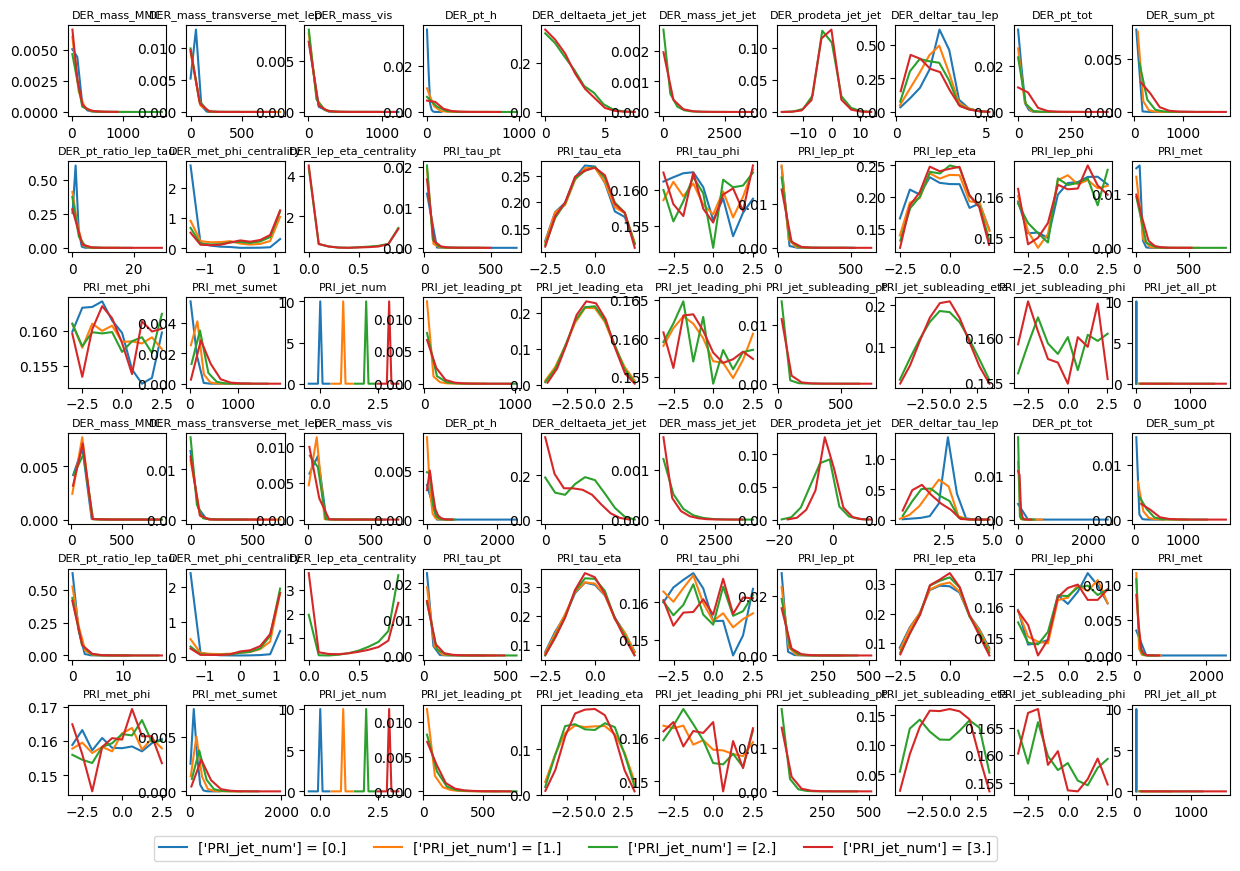

In [134]:
import matplotlib.pyplot as plt
import math

for var in [
    "_priors",
    # "_class_histograms",
    # "_bin_edges",
    # "_missing_value_probabilities",
    "_categorical_combinations",
    "_categorical_combination_probabilities",
    "_categorical_features",
    "_num_features",
    "_num_classes",
    "classes_",
]:
    print(f"{var}: {getattr(model, var)}")

# Plot the class histograms for each categorical combination and each class
num_cols = model._num_features // 3
num_rows_per_class = math.ceil(model._num_features / num_cols)
label_template = f"{str(df.columns[model._categorical_features].tolist())} = {{cat_comb}}"
fig, ax = plt.subplots(model._num_classes * num_rows_per_class, num_cols, figsize=(15, 10))
for j, class_label in enumerate(model.classes_):
    for class_idx in range(model._num_features):
        for comb_idx, cat_comb in enumerate(model._categorical_combinations):
            hist = model._class_histograms[j][comb_idx][class_idx]
            bin_edges = model._bin_edges[j][comb_idx][class_idx]
            ax_index = np.s_[j * num_rows_per_class + class_idx // num_cols, class_idx % num_cols]
            ax[ax_index].plot(
                bin_edges[:-1],
                hist,
                color=f"C{comb_idx}",
                label=label_template.format(cat_comb=cat_comb),
            )
            ax[ax_index].set_title(df.columns[class_idx], fontsize=8)
            # ax[ax_index].set_xlabel("Value")
            # ax[ax_index].set_ylabel("Density")
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.legend(ncol=len(model._categorical_combinations), loc="lower left", bbox_to_anchor=(-10, -0.8))

In [135]:
y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6583
              precision    recall  f1-score   support

           b       0.66      1.00      0.79    107736
           s       0.00      0.00      0.00     55912

    accuracy                           0.66    163648
   macro avg       0.33      0.50      0.40    163648
weighted avg       0.43      0.66      0.52    163648



c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

### Non-normal Naive Bayes Classifier with Kernel Density Estimation

Next, we will implement a non-normal Naive Bayes classifier that uses kernel density estimation (KDE) for each continuous feature. KDE is a non-parametric way to estimate the probability density function of a random variable famously used for Naive Bayes classifiers (Trevor Hastie et al.). We will use Gaussian kernels for this purpose.

#### Definition of KDE-based Naive Bayes Classifier

Let $(x_1, ..., x_n)$ be a set of independent and identically distributed samples drawn from some unknown probability density function $f$. The kernel density estimate $\hat{f}(x)$ of $f$ at a point $x$ is given by:

$$
\hat{f}(x) = \frac{1}{n} \sum_{i=1}^{n} K_h(x - x_i)
$$

where $K_h$ is the kernel function with bandwidth $h$, a smoothing parameter related to the variance of the estimator. For a Gaussian kernel, this is defined as:

$$
K_h(u) = \frac{1}{\sqrt{2\pi h^2}} \exp\left(-\frac{u^2}{2h^2}\right)
$$



## References

- Hastie, T., Tibshirani, R., & Friedman, J. (2001). The Elements of Statistical Learning: Data Mining, Inference, and Prediction: with 200 full-color illustrations. New York: Springer.